In [7]:
import random

import matplotlib.pyplot as plt
import numpy as np
from Crypto.Util.number import GCD as gcd, inverse
from IPython import display


# Prerequisites

- Elliptic curves over finite fields (implementation below)
- Group theory -> Finite fields
- Pollard p-1

In [4]:
class EllipticCurveFp(object):
    def __init__(self, a: int, b: int, p: int):
        """
        input a and b for the y^2 = x^3 + ax + b mod p. form

        """
        self.a = a % p
        self.b = b % p
        self.p = p

        self.discriminant = -16 * (4 * pow(a, 3, p) + 27 * pow(b, 2, p)) % p
        if not self.is_smooth():
            raise Exception("the curve %s is not smooth!" % self)

    def is_smooth(self):
        return self.discriminant != 0

    def test_point(self, x: int, y: int):
        return pow(y, 2, self.p) == ((pow(x, 3, self.p) + self.a * x + self.b) % self.p)

    def get_all_points(self):
        """gets points WITHOUT the ideal. The ideal is coded as (np.inf, np.inf)"""
        all_points = list()
        all_points.append(PointFp(self, 0, 1, 0))
        for x in range(self.p):
            y_sq = (pow(x, 3, self.p) + self.a * x + self.b) % self.p
            y = modular_sqrt(y_sq, self.p)
            if y != 0:  # 0 is when no root exists
                all_points.append(PointFp(self, x, y))
                all_points.append(PointFp(self, x, self.p - y))
        return all_points

    def __str__(self):
        return "y^2 = x^3 + %Gx + %G mod %G" % (self.a, self.b, self.p)

    def __eq__(self, other):
        return (self.a, self.b, self.p) == (other.a, other.b, other.p)


class PointFp(object):
    """
    a point on a curve
    for any point that is not the ideal z = 1
    we consider the ideal to have x = 0, y = 1, z = 0
    """

    def __init__(self, curve, x, y, z=1):
        if z == 1:
            self.curve = curve  # the elliptic curve containing the point
            self.x, self.y = x % curve.p, y % curve.p
            self.z = z
            if not curve.test_point(self.x, self.y):
                raise Exception("The point %s is not on the given curve %s" % (self, curve))
        else:
            self.x, self.y, self.z = x, y, z
            self.curve = curve

    def __neg__(self):
        return PointFp(self.curve, self.x, -self.y % self.curve.p)

    def __eq__(self, other):
        if self.curve == other.curve and self.x == other.x and self.y == other.y:
            return True
        else:
            return False

    def __add__(self, other):
        if self.z != 1:
            return other
        elif other.z != 1:
            return self
        elif self.x == other.x and self.y == -other.y % self.curve.p:
            return PointFp(self.curve, 0, 1, 0)
        else:
            # doubling
            if self == other:
                num = 3 * pow(self.x, 2) + self.curve.a
                denom = 2 * self.y
                gcd_temp = gcd(denom, self.curve.p)
                if gcd_temp != 1:
                    return PointFp(self.curve, 0, 0, denom)
                else:
                    lam = num * inverse(denom, self.curve.p)
            else:
                num = self.y - other.y
                denom = self.x - other.x
                gcd_temp = gcd(denom, self.curve.p)
                if gcd_temp != 1:
                    return PointFp(self.curve, 0, 0, denom)
                else:
                    lam = num * inverse(denom, self.curve.p)
            x_3 = (lam**2 - self.x - other.x) % self.curve.p
            y_3 = (lam * (self.x - x_3) - self.y) % self.curve.p
            return PointFp(self.curve, x_3, y_3)

    def __sub__(self, other):
        return self + -other

    def __str__(self):
        return "(%s, %s, %s)" % (self.x, self.y, self.z)

    def __mul__(self, n):
        n = n % self.curve.p
        if not isinstance(n, int):
            raise Exception("can't scale if n isnt integer")
        else:
            if n == 0:
                return PointFp(self.curve, 0, 1, 0)
            else:
                Q = self
                R = self if n & 1 == 1 else PointFp(self.curve, 0, 1, 0)
                i = 2
                while i <= n:
                    Q = Q + Q
                    if n & i == i:
                        R = Q + R
                    i = i << 1
        return R

    def __rmul__(self, n):
        return self * n

    def __hash__(self):
        return hash(str(self))

# Theory

- [Jeff Suzuki's video](https://www.youtube.com/watch?v=x6vyBb4915Q&list=PLKXdxQAT3tCssgaWOy5vKXAR4WTPpRVYK&index=82&ab_channel=JeffSuzuki)
- [Wikipedia entry](https://en.wikipedia.org/wiki/Lenstra_elliptic-curve_factorization)https

**Lagrange's theorem**:
For any finite group $G$, the order (number of elements) of every subgroup $H$ of $G$ divides the order of $G$.

Let $ E: \ Y^2 = X^3 + AX + B  \bmod  N$ where N is not necesarily prime => Let $N = pq$ => 
- Since $N$ is finite, there must be some $k$ for which $kP = 0$ (The point at infinity)
- Therefore the line between $(k-1)P$ and $P$ must have undefined slope
- This will occur when the difference of the $x$-values shares a common factor with $N$

*Intuition 1*:
- $N$ will have subgroups with $N_p$, $N_q$ elements -> from Lagrange's theorem you'll find a $k$ s.t $kP = 0$. Moreover $k = N_p$ which divides N

*Intuition 2*:
- We choose random curves so there is a good chance that we stumble upon a curve with a number of points that is equal to a product of small primes
- The difficulty lies in computing $\lambda$ (the slope) , because the ring $\mathbb{Z}/n\mathbb{Z}$ is not a field so $x_2 - x_1$ might not have an inverse
- If we find $1 < \gcd(x_2-x_1,N) < N$ then there is no inverse therefore we can't compute $\lambda$ but we don't care since we found a factor of $N$

# Code

Algorithm:

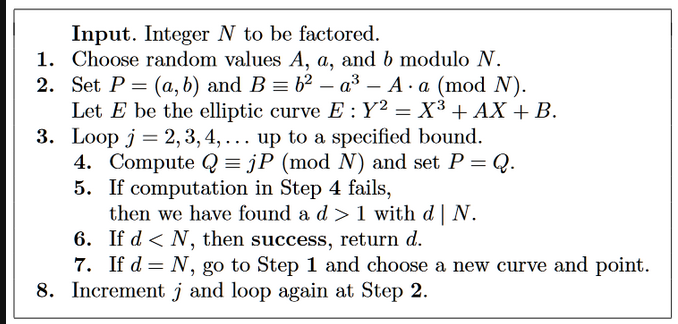
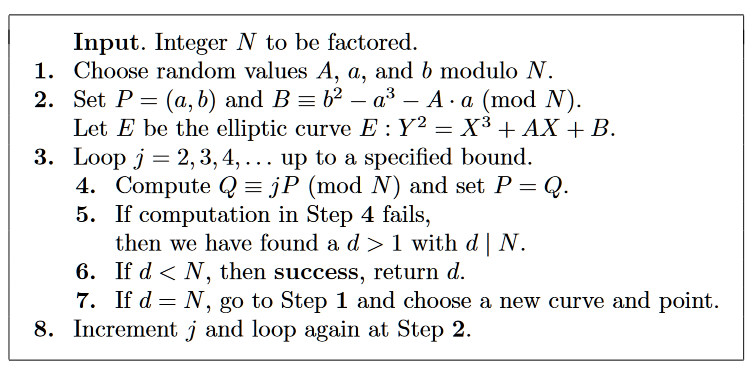

In [8]:
def lenstra_factorization_ec(n: int, bound: int = 10000):
    """Lenstra Facorization method

    Parameters
    ----------
    n : int
        Number to be factored

    bound : int, default=10000
        Bound for searching for kP = 0


    Returns
    -------
    int
        Factor of n
    """
    # select random values A, x_p, y_p
    while True:
        A = random.randint(0, max(10, n - 1 // 10))
        x_p = random.randint(0, n - 1)
        y_p = random.randint(0, n - 1)

        # compute B
        B = (pow(y_p, 2, n) - pow(x_p, 3, n) - A * x_p) % n

        # set the elliptic curve and the point
        E = EllipticCurveFp(A, B, n)
        P = PointFp(E, x_p, y_p)

        for j in range(2, bound):  # or to a specific bound
            Q = j * P
            # print('Q = ', Q)
            if Q.z != 1 and Q.z != 0:
                # we found the denominator that can't be inverted
                d = Q.z
                gcd_temp = gcd(d, n)
                if gcd_temp < n:
                    return gcd_temp
                else:
                    break  # if it fails choose another curve
            P = Q

In [10]:
n = 26167
f = lenstra_factorization_ec(n)
print(f, n % f)
n = 28102844557
f = lenstra_factorization_ec(n)
print(f, n % f)

137 0
117763 0
